In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt

## Data preparation

In [3]:
### VERSION 1
#df = pd.read_csv('./data_cleaned.csv')


#df = df.drop(columns=['W'])
# Separate the features (inputs) and output (outputs)
#features = df[['y/delta', 'y^+', 'Re_tau', 'U', 'P', 'dU/dy']]
#output = df[['u\'u\'', 'v\'v\'', 'w\'w\'', 'u\'v\'', 'u\'w\'', 'v\'w\'', 'k']]



### VERSION 2 
df = pd.read_csv('../TurbulenceModelPINN/data/couette/train_dataset.csv')

features = df[[
    "y/delta",
    "y^+",
    "u_tau",
    "nu",
    "Re_tau"
]]
output = df[[
    "u'u'",
    "v'v'",
    "w'w'",
    "u'v'",
    "U",
    "dU/dy",
    "P",
    "k",
]]
display(df.head(5))
df.shape

,y/delta,y^+,U,dU/dy,W,P,nx,ny,nz,Lx,...,u'u',v'v',w'w',u'v',u'w',v'w',k,u'p',v'p',w'p'
0,0.075843,16.646039,11.072629,0.280459,0.000145,-0.392390,6144,192,768,314.159265,...,8.814468,0.392390,1.837154,-0.719578,-0.001295,-0.000028,5.522006,0.550078,-0.176205,0.000720
1,0.756388,165.764907,17.525914,0.014784,-0.001440,-1.275931,1280,192,768,62.831853,...,5.073383,1.275931,1.664586,-0.985199,0.005556,-0.000024,4.006950,0.156460,-0.057687,0.001287
2,0.031977,16.032114,10.894402,0.299072,0.000315,-0.372960,15360,256,1536,314.159265,...,9.747802,0.372960,2.033197,-0.700910,0.000239,-0.000013,6.076979,0.536112,-0.186262,-0.002556
3,0.589939,296.523992,18.999163,0.006914,0.002266,-1.164602,3072,256,1536,62.831853,...,6.609519,1.164602,1.706016,-0.994051,0.007912,-0.000034,4.740069,0.226820,-0.112506,-0.001983
4,0.178106,89.522160,16.124254,0.026570,0.001720,-1.229319,3072,256,1536,62.831853,...,6.755220,1.229319,2.449605,-0.973646,0.007758,-0.000121,5.217072,0.648275,-0.225897,0.000158


(391, 27)

In [4]:



# Normalize the features and output
scaler_features = StandardScaler().fit(features)
scaler_output = StandardScaler().fit(output)
features_normalized = scaler_features.transform(features)
output_normalized = scaler_output.transform(output)

# Split the dataset into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    features_normalized, output_normalized, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Convert the numpy arrays into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



## Create Tranformer architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RegressionTransformer(nn.Module):
    def __init__(self, input_features, num_transformer_layers, transformer_heads, model_dim, forward_expansion, output_features):
        super(RegressionTransformer, self).__init__()

        # Embedding layer to increase dimensionality
        self.embedding = nn.Linear(input_features, model_dim)

        # Transformer Encoder Layer
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=transformer_heads,
            dim_feedforward=model_dim * forward_expansion,
            dropout=0.1
        )

        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers, num_layers=num_transformer_layers)

        # Output layer
        self.output_layer = nn.Linear(model_dim, output_features)

    def forward(self, x):
        # Increase dimensionality and apply positional encoding if needed
        x = self.embedding(x)

        # Pass through the Transformer encoder
        x = self.transformer_encoder(x)

        # Predict output features
        output = self.output_layer(x)
        return output


# Model instantiation
input_features = 5
output_features = 8
model_dim = 512  # Size of the embedding and model dimension
num_transformer_layers = 4  # Number of transformer layers
transformer_heads = 8  # Number of heads in multi-head attention mechanism
forward_expansion = 4  # Expansion of size in the feedforward layer


model = RegressionTransformer(input_features, num_transformer_layers,
                              transformer_heads, model_dim, forward_expansion, output_features)

print(model)

RegressionTransformer(
  (embedding): Linear(in_features=5, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=512, out_features=8, bias=True)
)


c:\Users\julie\Mon Drive (julien.godfroy27@gmail.com)\Travail ISEP\Cranfield\Group project\GroupProjectFirstAnalysis\.venv\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## train

In [6]:
import torch.optim as optim

# Hyperparameters
learning_rate = 1e-4
batch_size = 64
epochs = 60

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# DataLoader for batch processing
train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True)

val_data = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=batch_size, shuffle=False)

# Lists to store loss values
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
        val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(
        f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Optionally, save your model
# torch.save(model.state_dict(), 'regression_transformer_model.pth')


Epoch [1/60], Loss: 0.9180, Val Loss: 0.9521
Epoch [2/60], Loss: 0.5510, Val Loss: 0.6301
Epoch [3/60], Loss: 0.4284, Val Loss: 0.5225
Epoch [4/60], Loss: 0.3328, Val Loss: 0.3947
Epoch [5/60], Loss: 0.2643, Val Loss: 0.2480
Epoch [6/60], Loss: 0.1997, Val Loss: 0.1623
Epoch [7/60], Loss: 0.1475, Val Loss: 0.1683
Epoch [8/60], Loss: 0.1355, Val Loss: 0.1203
Epoch [9/60], Loss: 0.1531, Val Loss: 0.0729
Epoch [10/60], Loss: 0.0942, Val Loss: 0.1422
Epoch [11/60], Loss: 0.1103, Val Loss: 0.0495
Epoch [12/60], Loss: 0.0695, Val Loss: 0.1275
Epoch [13/60], Loss: 0.0983, Val Loss: 0.2038
Epoch [14/60], Loss: 0.1207, Val Loss: 0.0972
Epoch [15/60], Loss: 0.1370, Val Loss: 0.1317
Epoch [16/60], Loss: 0.0730, Val Loss: 0.0580
Epoch [17/60], Loss: 0.0722, Val Loss: 0.0603
Epoch [18/60], Loss: 0.0464, Val Loss: 0.0260
Epoch [19/60], Loss: 0.0519, Val Loss: 0.0424
Epoch [20/60], Loss: 0.0672, Val Loss: 0.0432
Epoch [21/60], Loss: 0.0648, Val Loss: 0.1577
Epoch [22/60], Loss: 0.0952, Val Loss: 0.06

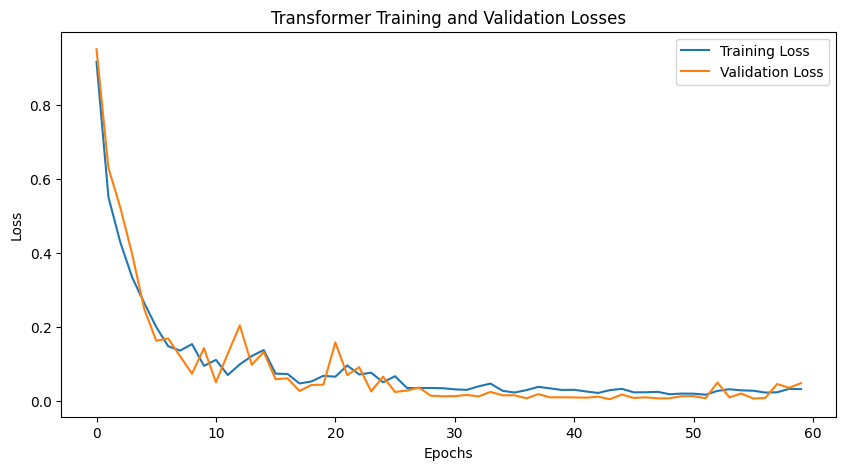

In [7]:
import matplotlib.pyplot as plt

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Transformer Training and Validation Losses')
plt.show()

In [23]:
#test model

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor).item()
    print(f'Test Loss: {test_loss:.4f}')

    

Test Loss: 0.0042
